In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\P812_M050_2_B_FoG_trials.mat
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_right_foot.csv
.\data\P812_M50_2_B_FoG_trial2_annotation.csv


In [3]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv')
t1olf = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv')
emg_data2 = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_2_emg.csv')

In [4]:
emg_data.head()

,Time,Label1,Label2,LEFT_TA,LEFT_TS,LEFT_BF,LEFT_RF,RIGHT_TA,RIGHT_TS,RIGHT_BF,RIGHT_RF
0,0.000,0,0,-3,2,-4.0,-1.0,0.0,2.0,1.0,-2.0
1,0.001,0,0,-5,10,0.0,-2.0,-4.0,0.0,-7.0,-2.0
2,0.002,0,0,-6,11,1.0,0.0,-4.0,-1.0,-2.0,-3.0
3,0.003,0,0,0,-2,0.0,-3.0,-6.0,-2.0,-5.0,-8.0
4,0.004,0,0,0,-8,-3.0,-3.0,-4.0,-3.0,0.0,2.0


In [5]:
emg_data2.head()

,Time,Label1,Label2,LEFT_TA,LEFT_TS,LEFT_BF,LEFT_RF,RIGHT_TA,RIGHT_TS,RIGHT_BF,RIGHT_RF
0,0.000,0,0,-14,-4,-4,-1,-9,-2,1.0,-1.0
1,0.001,0,0,-5,-4,-4,-4,-6,-1,0.0,6.0
2,0.002,0,0,6,0,-9,4,-6,-6,0.0,-2.0
3,0.003,0,0,28,1,-1,-1,1,2,-5.0,2.0
4,0.004,0,0,43,3,-2,0,1,2,3.0,1.0


In [94]:
def generate_window_slide_data(data,width = 260, stride = 30):
    l = len(data)
    end = (l-width)//stride+1
    X = np.zeros((1,width,8))
    #Y = np.zeros((end))
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
            if i == 0:
                Y = np.array([data.Label2[i]])
                X[0] =emg_data.iloc[:width,3:]
            else:
                Y = np.concatenate((Y,[data.Label2[i*stride]]))
                X = np.concatenate((X,[np.array(data.iloc[i*stride:i*stride+width,3:])]))
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return X,Y

def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c))
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
    return cwtmatr

In [95]:
x,y = generate_window_slide_data(emg_data)

In [99]:
cwtmatr = generate_CWT_feature(x)
#x[1,:,1]

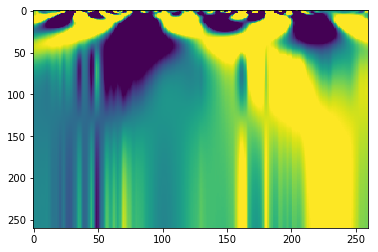

In [111]:
plt.imshow(cwtmatr[2160,:,:,0], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[0,:,:,0]).max(), vmin=-abs(cwtmatr[0,:,:,0]).max())

In [110]:
y[2160]

2

In [91]:
np.concatenate(([emg_data.Label2[1]],[emg_data.Label2[1]]))

array([0, 0], dtype=int64)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.
